In [ ]:
! ls /home/ian.harry/tmp_abi

In [1]:
#Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import sem

#Machine learning tool

import keras
import tensorflow 
from keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, GlobalAveragePooling2D, Convolution2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image

from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

import torch
from nnAudio.Spectrogram import CQT1992v2
import efficientnet.tfkeras as efn

2022-05-23 02:31:37.156248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-23 02:31:37.156302: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/abi.abraham/.local/lib/python3.9/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [2]:
# I am using concepts and certain codes used by Mrigendra Agrwal from Kaggle.
#Reference https://www.kaggle.com/code/mrigendraagrawal/tf-g2net-eda-and-starter

In [3]:
#Read in the training labels csv
training_labels = pd.read_csv("/home/ian.harry/tmp_abi/training_labels.csv")

path = list(training_labels['id'])
for i in range(len(path)):
    path[i] = '/home/ian.harry/tmp_abi/train/' + path[i][0] +  '/' + path[i][1] +  '/' + path[i][2] +  '/' + path[i] + '.npy'
    



In [4]:
#Function to set a path to call in the data and assign paths
def path2id(idx,is_train = True):
    path = '/home/ian.harry/tmp_abi'
    if is_train:
        path += '/train/' + idx[0] + '/' + idx[1] + '/' + idx[2] + '/' + idx + '.npy'
    else:
        path += '/train/' + idx[0] + '/' + idx[1] + '/' + idx[2] + '/' + idx + '.npy'
    return path

In [5]:
#function to convert the timseries into a image 
def increase_dimension(idx,is_train,transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)): 
    
    waves = np.load(path2id(idx,is_train))
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    image = np.array(image)
    image = np.transpose(image,(1,2,0))
    return image

CQT kernels created, time used = 0.0930 seconds


/home/abi.abraham/.local/lib/python3.9/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [8]:
ex_ts.savefig("ex_ts.pdf",format="pdf", bbox_inches ="tight")

In [9]:
#Dataset Generator 
class Dataset(Sequence):
    
    def __init__(self,idx,y=None,batch_size=32, shuffle= True):
        self.idx = idx
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if y is not None:
            self.is_train=True
        else:
            self.is_train=False
        self.y = y
        
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
    
    def __getitem__(self,ids):
        batch_ids = self.idx[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        list_x = np.array([increase_dimension(x,self.is_train) for x in batch_ids])
        batch_X = np.stack(list_x)
        
        if self.is_train:
            return batch_X, batch_y
        else:
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))
    
    def debug(self):
        return self.idx

In [10]:
#Reducing the size of dataset 
train_data_size = len(training_labels['id'].values)//50 #reducing the data size to 11200
train_idx = training_labels['id'].values[0:train_data_size]
valid_idx = training_labels['target'].values[0:train_data_size]
test_idx =  training_labels['id'].values[11200:22400]

In [11]:
print(len(train_idx))
print(len(test_idx))

11200
11200


In [12]:
#Spliting the dataset in to train and test sets
x_train, x_test, y_train, y_test = train_test_split(train_idx,valid_idx,test_size=0.05, random_state=None, stratify=valid_idx)

In [13]:
#Applying the dataset generator to train, test and validation sets
train_dataset = Dataset(x_train,y_train)
valid_dataset = Dataset(x_test, y_test)
test_dataset  = Dataset(test_idx)
len(y_train)

10640

In [14]:
#Building the CNN model
model = Sequential([keras.layers.InputLayer(input_shape=(27,128,1)), Convolution2D(3,3,activation='relu',padding='same'), 
                   efn.EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'), 
                   GlobalAveragePooling2D(),
                   Dense(256,activation='relu'),
                   Dense(128,activation='relu'),
                   Dense(64,activation='relu'), 
                   Dense(1,activation='sigmoid')])

model.summary()
model.compile(optimizer= Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=["accuracy"])

2022-05-23 02:32:52.088886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-23 02:32:52.089081: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-23 02:32:52.089174: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ldas-pcdev14): /proc/driver/nvidia/version does not exist
2022-05-23 02:32:52.090705: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 128, 3)        30        
                                                                 
 efficientnet-b0 (Functional  (None, None, None, 1280)  4049564  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [ ]:
#Training the model
model.fit(train_dataset, validation_data=valid_dataset, use_multiprocessing=True,
          epochs = 5)

In [ ]:
model.save('Project/Model')

In [17]:
loaded_model = keras.models.load_model('Project/Model')

In [18]:
df = pd.DataFrame(list()) 
df.to_csv('predsv1.csv')
predsv1 = pd.read_csv('predsv1.csv')

In [19]:
#Model prediciting the using the test sets
model_pred = loaded_model.predict(test_dataset, use_multiprocessing=True,verbose=1)
model_pred = model_pred.reshape(-1)

350/350 [==============================] - 1867s 5s/step


In [20]:
print(len(training_labels))
print(len(train_idx))
print(len(model_pred))

560000
11200
11200


In [21]:
train_data_size2 = len(y_train)
test_idx2 = training_labels['id'].values[11200:22400]

targets_s = training_labels['target']
tar_len = (len(targets_s)//50) 
targets = training_labels['target'].values[11200:22400]
print(len(targets))

11200


In [22]:
print(model_pred)
print(len(model_pred))

[0.96508336 0.95668286 0.4818788  ... 0.6210368  0.7584832  0.99580324]
11200


In [30]:
model_target = np.array(model_pred)
model_target[:,] = model_target[:,]>0.71 # setting threshold to create a binary classification
model_targets = model_target.astype(int)
print(model_targets)
print(len(targets)) 
    

[1 1 0 ... 0 1 1]
11200


In [29]:
#To find the best threshold
threshs = np.linspace(0,1,10000)

max_icv = 0

for th in threshs:

    icv = predsv1['Model Predictions'] > th
    curr_th = sum(icv == predsv1['Actual Targets']) / len(predsv1)
    if curr_th > max_icv:
        max_icv = curr_th
        max_th = th
print(max_icv, max_th)

0.7548214285714285 0.718971897189719


In [31]:
#Converting the model predicition to 1 and 0s considering the threshold
target_frac = []
mod_tar = list(model_targets)
act_tar = list(targets)

for i in range(len(mod_tar)):
    if mod_tar[i] == act_tar[i]:
        target_frac.append(1)
    else: 
        target_frac.append(0)

In [32]:
predsv1 = pd.DataFrame({'id':test_idx2,'Model Predictions':model_pred, 
                      'Model Targets':model_targets,
                      'Actual Targets' : targets,
                      'Classified Targets': target_frac})

predsv1.to_csv('predsv1.csv',index = False)

In [33]:
predsv1.head(10)

,id,Model Predictions,Model Targets,Actual Targets,Classified Targets
0,0512c12234,0.965083,1,1,1
1,0512c43788,0.956683,1,1,1
2,0512f94477,0.481879,0,1,0
3,051303dc5a,0.388922,0,0,1
4,051351f27f,0.462480,0,1,0
5,0513678d6c,0.734983,1,1,1
6,05136fbb2a,0.986520,1,1,1
7,0513b1af7b,0.626744,0,0,1
8,0513d9c254,0.545113,0,0,1
9,0513e7624c,1.000000,1,1,1


In [34]:
num_ones = np.count_nonzero(target_frac)
acc_score = (num_ones/len(target_frac))*100
error_score = (100-acc_score)
print('Classfied Correctly: ', acc_score, 'Classfied Incorrectly: ', error_score)


Classfied Correctly:  75.38392857142857 Classfied Incorrectly:  24.61607142857143


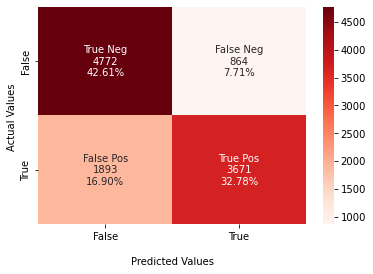

In [39]:
cm = confusion_matrix(act_tar,mod_tar) #Computes a confusion matrix 
group_names = ['True Neg','False Neg','False Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')


ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
cm_CNN = plt.gcf()

In [41]:
cm_CNN.savefig('cm_CNNv1.pdf',format='pdf',bbox_inches='tight')